<a href="https://colab.research.google.com/github/bpalas/proportionagreement/blob/main/Comparaci%C3%B3n_modelos_proportion_agreement_graph_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumen :


| Model                             | Training_R2 | Training_RMSE | Training_RSR | Training_VAF | ***Testing_R2*** | Testing_RMSE | Testing_RSR | Testing_VAF |
|------------------------------------|-------------|---------------|--------------|--------------|------------|--------------|-------------|-------------|
| Modelo Base                        | 0.443833    | 0.233776      | 0.233776     | 0.443833     | ***0.557045***   | 0.218785     | 0.218785    | 0.557045    |
| Representación de edge  con concatenación | 0.832438    | 0.128317      | 0.128317     | 0.832438     | ***0.751565***  | 0.163849     | 0.163849    | 0.751565    |
| Representación de edge  con producto       | 0.815328    | 0.134709      | 0.134709     | 0.815328     | ***0.762219***   | 0.160298     | 0.160298    | 0.762219    |
| Representación de edge  con promedio       | 0.874291    | 0.111142      | 0.111142     | 0.874291     | ***0.589620***   | 0.210587     | 0.210587    | 0.589620    |

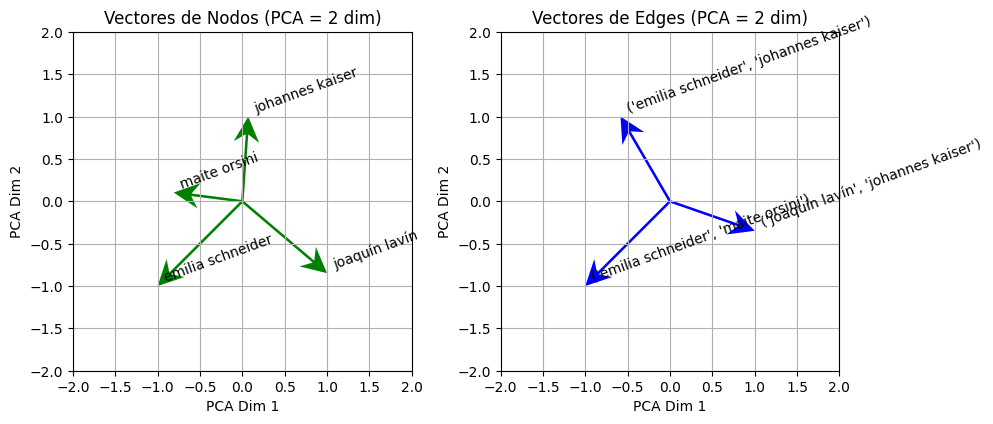

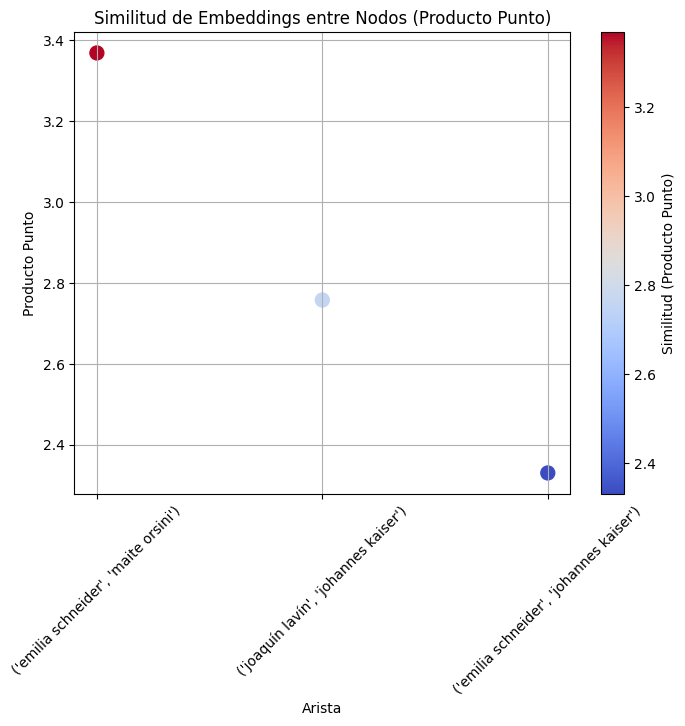

## Regresión :
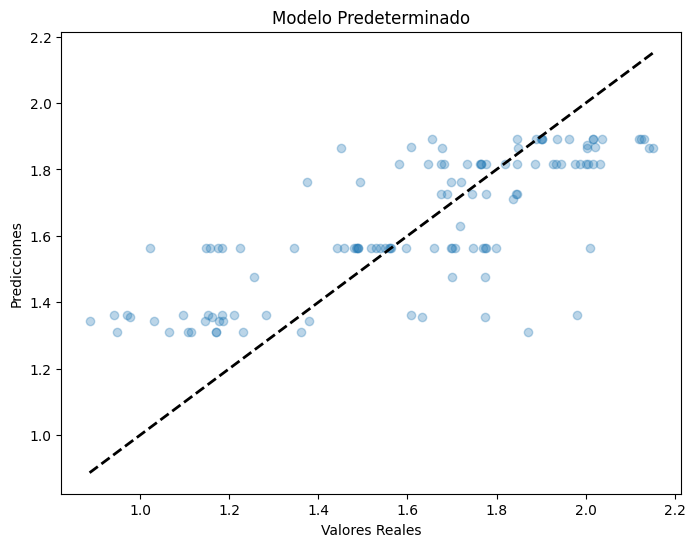

## Representación de edge  con concatenación :
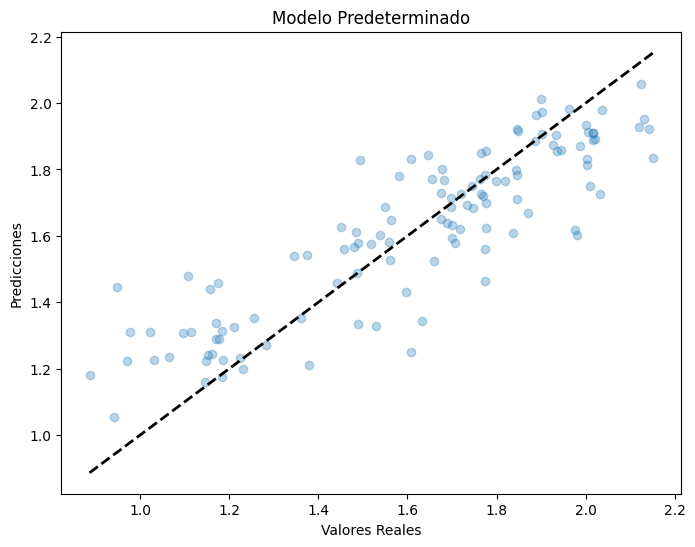


# Resto del notebook


In [ ]:
!pip install node2vec
!pip install shap  --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.3 MB/s eta 0:00:00


In [ ]:
!pip3 install nodevectors

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import pandas as pd
from matplotlib import pyplot as plt
import shap
import pandas as pd

In [ ]:

url = 'https://raw.githubusercontent.com/bpalas/proportionagreement/main/final_edgelist.csv'

# Leer el archivo CSV desde la URL
df_merged = pd.read_csv(url)


# Node2vec

In [ ]:

import networkx as nx
sentiment_weights = {
    'positive': 5,
    'neutral': 2.5,
    'negative': 0.000000000001        # Representarlo por 0 o negativo causa problemas al usar el modelo node2vec, dejarlo expresado asi da buenos resultados
}

# Crear una columna 'weight' en el DataFrame basada en los sentimientos
df_merged['weight'] = df_merged['sentiment'].map(sentiment_weights)

G = nx.from_pandas_edgelist(df_merged, 'person_1', 'person_2', edge_attr='weight')



from node2vec import Node2Vec as n2v
# Crear el modelo node2vec
node2vec = Node2Vec(G, dimensions=128, walk_length=15, num_walks=200, workers=4)

# Entrenar el modelo
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Obtener los vectores de nodos
node_vectors = model.wv


Computing transition probabilities:   0%|          | 0/153 [00:00<?, ?it/s]

In [ ]:
node_vector_df = pd.DataFrame([node_vectors[node] for node in G.nodes()], index=list(G.nodes()))
len(node_vector_df)

153

In [ ]:
for node, _ in model.wv.most_similar('emilia schneider'):
    print(node)


jaime sáez
cid
eric aedo
boris barrera
héctor barría
cosme mellado
camila rojas
marcos ilabaca
gonzalo winter
maite orsini


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd


pca = PCA()
node_vector_pca = pca.fit_transform(node_vector_df)

# Calcular la varianza explicada acumulada por cada componente
explained_variance = pca.explained_variance_ratio_.cumsum()

# Verificar la varianza explicada acumulada
print(explained_variance)


[0.12846224 0.23881572 0.3198407  0.38672307 0.44479486 0.49865246
 0.54486096 0.58374095 0.61910075 0.65154564 0.6784108  0.7017917
 0.7235268  0.74347496 0.76016605 0.7762271  0.7906709  0.8022345
 0.81321514 0.8230751  0.83191854 0.8398895  0.8464764  0.85295343
 0.8588482  0.86444926 0.86987334 0.87483174 0.87960535 0.88408464
 0.88848066 0.89266324 0.8968386  0.90089875 0.90492207 0.90881234
 0.91260934 0.916191   0.9197479  0.9232511  0.92655426 0.9298278
 0.93301874 0.93615496 0.93916905 0.94214964 0.94503456 0.9478674
 0.950644   0.9533241  0.9559119  0.9584279  0.96086293 0.96323615
 0.96559376 0.9677906  0.96987617 0.9718877  0.97385025 0.97574407
 0.9775239  0.9792426  0.9809446  0.98257613 0.9841187  0.9855865
 0.98698556 0.9882876  0.9894767  0.99055445 0.9915507  0.9924447
 0.99330723 0.9940784  0.9947664  0.99537295 0.99594665 0.9964445
 0.99692416 0.99735147 0.9977418  0.99803966 0.9983137  0.9985456
 0.99876493 0.9989427  0.9990842  0.999196   0.99930394 0.9994069
 0.9

In [ ]:
n_components =  12

In [ ]:
from sklearn.decomposition import PCA

# Volver a aplicar PCA con el número óptimo de componentes
pca_optimal = PCA(n_components=n_components)
node_vector_reduced = pca_optimal.fit_transform(node_vector_df)

# Convertir los vectores de nodos reducidos a un DataFrame
node_vector = pd.DataFrame(node_vector_reduced, index=node_vector_df.index, columns=[f'x{i+1}' for i in range(n_components)])

len(node_vector)

153

# Construcción edge

In [ ]:
def get_node_vector(person_name):
    if person_name in node_vector.index:
        return tuple(node_vector.loc[person_name])
    else:
        return tuple([None] * node_vector.shape[1])

df_merged['node_vector_1'] = df_merged['person_1'].apply(get_node_vector)
df_merged['node_vector_2'] = df_merged['person_2'].apply(get_node_vector)


In [ ]:
# Similitud de partido (1 si son del mismo partido, 0 si no)
df_merged['same_party'] = (df_merged['partido_1'] == df_merged['partido_2']).astype(int)

# Similitud de sector político (1 si es el mismo sector, 0 si no)
df_merged['same_sector'] = (df_merged['sector_1'] == df_merged['sector_2']).astype(int)

# Similitud de región (1 si es la misma región, 0 si no)
df_merged['same_region'] = (df_merged['region_1'] == df_merged['region_2']).astype(int)

df_merged['same_comunity'] = (df_merged['community_1'] == df_merged['community_2']).astype(int)

In [ ]:
# Crear un diccionario de mapeo
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}

# Reemplazar los valores en la columna 'sentiment'
df_merged['sentiment'] = df_merged['sentiment'].map(sentiment_mapping)



# Plot edge2vec

In [ ]:
pip install networkx gensim numpy


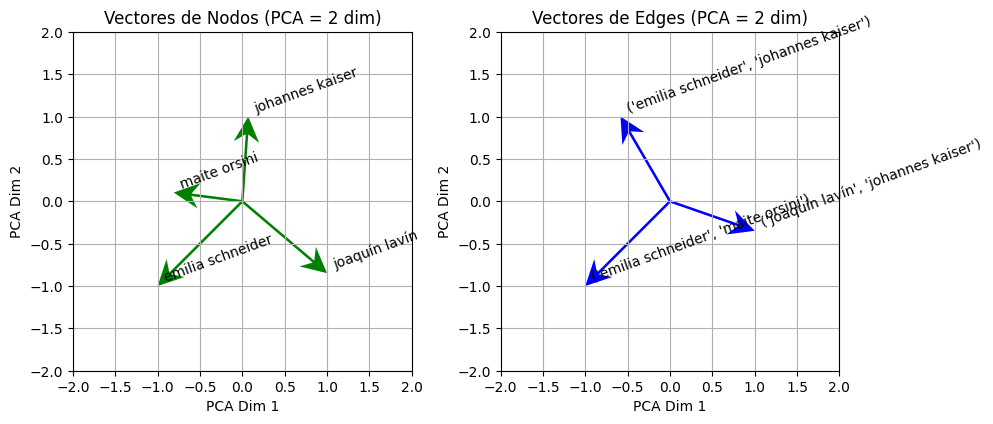

In [ ]:
# @title Plot edge2vec
import networkx as nx
import numpy as np
from gensim.models import Word2Vec
def get_edge_embedding_product(model, edge):
    node1, node2 = edge
    # Get the vector embeddings of node1 and node2
    embedding1 = model.wv[node1]
    embedding2 = model.wv[node2]
    # Compute element-wise product
    edge_embedding = embedding1 * embedding2
    return edge_embedding

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# Obtener embeddings de edges para aristas seleccionadas y concatenar con las características
edges = [('emilia schneider', 'maite orsini'), ('joaquín lavín', 'johannes kaiser'), ('emilia schneider', 'johannes kaiser')]
edge_embeddings = []
for edge in edges:
    # Obtener el embedding del edge
    edge_embedding = get_edge_embedding_product(model, edge)

    # Obtener los atributos del dataframe correspondientes a este edge
    row = df_merged[(df_merged['person_1'] == edge[0]) & (df_merged['person_2'] == edge[1])]
    if not row.empty:
        attributes = row[['same_party', 'same_sector', 'same_region', 'sentiment']].values[0]
        # Concatenar los atributos al embedding del edge
        extended_edge_embedding = np.concatenate((edge_embedding, attributes))
        edge_embeddings.append(extended_edge_embedding)
    else:
        # Si no hay atributos para el edge, solo usar el embedding del edge
        edge_embeddings.append(edge_embedding)

# Convertir edge_embeddings a un array numpy
edge_embeddings = np.array(edge_embeddings)

# Obtener los embeddings de nodos correspondientes a los nodos en los edges seleccionados
nodes = set([node for edge in edges for node in edge])
node_embeddings = np.array([model.wv[node] for node in nodes])
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

pca_nodes = PCA(n_components=2)
node_embeddings_2d = pca_nodes.fit_transform(node_embeddings)

pca_edges = PCA(n_components=2)
edge_embeddings_2d = pca_edges.fit_transform(edge_embeddings)

# Normalizar los embeddings para mantener una escala uniforme
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
node_embeddings_2d_scaled = scaler.fit_transform(node_embeddings_2d)
edge_embeddings_2d_scaled = scaler.fit_transform(edge_embeddings_2d)

# Visualizar los gráficos de nodos y edges como flechas (vectores) centradas en el origen
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Centralizar los puntos de inicio en el origen (0,0)
zero_origin_x = np.zeros(len(node_embeddings_2d_scaled))
zero_origin_y = np.zeros(len(node_embeddings_2d_scaled))

# Gráfico 1: Vectores de nodos centralizados en (0, 0)
ax1.quiver(zero_origin_x, zero_origin_y, node_embeddings_2d_scaled[:, 0], node_embeddings_2d_scaled[:, 1],
           angles='xy', scale_units='xy', scale=1, color='green', headwidth=10, headlength=10, headaxislength=7)

# etiquetas
for i, node in enumerate(nodes):
    ax1.annotate(f'{node}', (node_embeddings_2d_scaled[i, 0] + 0.05, node_embeddings_2d_scaled[i, 1] + 0.05),
                 fontsize=10, rotation=20)

ax1.set_title('Vectores de Nodos (PCA = 2 dim)')
ax1.set_xlabel('PCA Dim 1')
ax1.set_ylabel('PCA Dim 2')
ax1.grid(True)
ax1.set_aspect('equal')

# Ajustar los límites para ampliar el gráfico
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])

# Gráfico 2: Vectores de edges centralizados en (0, 0)
zero_origin_x_edges = np.zeros(len(edge_embeddings_2d_scaled))
zero_origin_y_edges = np.zeros(len(edge_embeddings_2d_scaled))

ax2.quiver(zero_origin_x_edges, zero_origin_y_edges, edge_embeddings_2d_scaled[:, 0], edge_embeddings_2d_scaled[:, 1],
           angles='xy', scale_units='xy', scale=1, color='blue', headwidth=10, headlength=10, headaxislength=7)

# Etiquetas
for i, edge in enumerate(edges):
    ax2.annotate(f'{edge}', (edge_embeddings_2d_scaled[i, 0] + 0.05, edge_embeddings_2d_scaled[i, 1] + 0.05),
                 fontsize=10, rotation=20)

ax2.set_title('Vectores de Edges (PCA = 2 dim)')
ax2.set_xlabel('PCA Dim 1')
ax2.set_ylabel('PCA Dim 2')
ax2.grid(True)
ax2.set_aspect('equal')

# Ajustar los límites para ampliar el gráfico
ax2.set_xlim([-2, 2])
ax2.set_ylim([-2, 2])

# Mostrar el gráfico
plt.tight_layout()
plt.show()


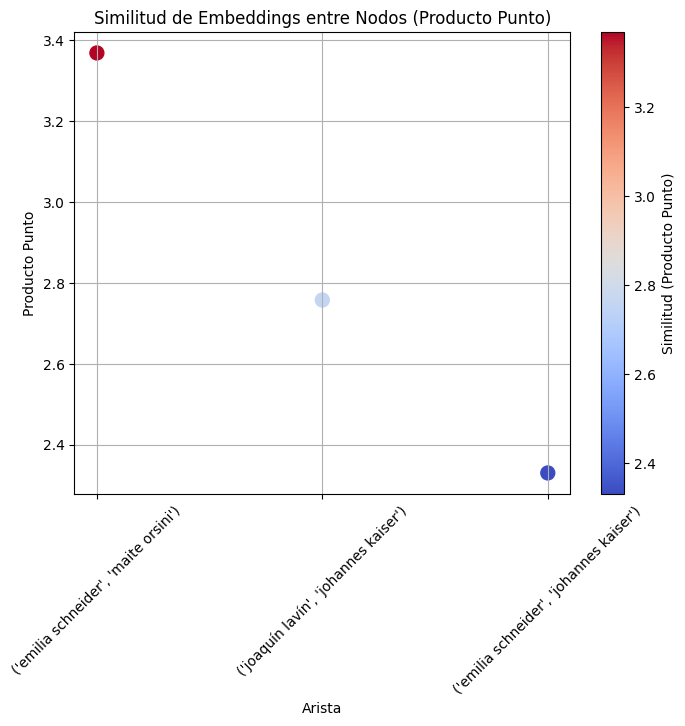

In [ ]:
# @title Plot Edge similarity

# Obtener los valores de los productos punto para cada arista
edge_similarities = [get_edge_embedding_product(model, edge) for edge in edges]

# Visualizar los valores de las aristas como un gráfico de dispersión con color
plt.figure(figsize=(8, 6))
plt.scatter(range(len(edge_similarities)), edge_similarities, c=edge_similarities, cmap='coolwarm', s=100)
plt.colorbar(label='Similitud (Producto Punto)')
plt.xticks(range(len(edges)), edges, rotation=45)
plt.title('Similitud de Embeddings entre Nodos (Producto Punto)')
plt.xlabel('Arista')
plt.ylabel('Producto Punto')
plt.grid(True)
plt.show()


# Métricas de Evaluación

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Crear el DataFrame vacío para almacenar los resultados
results_df = pd.DataFrame(columns=['Model', 'Training_R2', 'Training_RMSE', 'Training_RSR', 'Training_VAF',
                                   'Testing_R2', 'Testing_RMSE', 'Testing_RSR', 'Testing_VAF'])

# Definir la función para calcular RSR y VAF
def calculate_rsr_vaf(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = r2_score(y_true, y_pred)
    rsr = np.sqrt(ss_res / len(y_true))
    vaf = 1 - (ss_res / ss_tot)
    return rsr, vaf

# Regresión

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Regresión Base

In [ ]:
import pandas as pd

# Concatenar las columnas expandidas con el DataFrame original
X = df_merged[['same_party', 'same_sector', 'same_region', 'sentiment']]
y = df_merged['proportion_agreement']

In [ ]:
df_merged

,parliamentarian_1,parliamentarian_2,proportion_agreement,region_1,region_2,partido_1,partido_2,Diputado_1,Diputado_2,sector_1,...,community_1,community_2,weight,color,node_vector_1,node_vector_2,same_party,same_sector,same_region,same_comunity
0,"Barchiesi, Chiara","Castillo, Nathalie",0.876153,Región de Valparaíso (16),Región de Coquimbo (7),PLR,PCCh,Chiara Barchiesi Chavez,Nathalie Castillo Rojas,derecha,...,3.0,2.0,1.000000e-12,blue,"(-0.20825381577014923, 1.1615614891052246, -0....","(-0.6600958704948425, 0.518440842628479, -0.77...",0,0,0,0
1,"Barchiesi, Chiara","Pizarro, Lorena",0.878788,Región de Valparaíso (16),Región Metropolitana de Santiago (47),PLR,PCCh,Chiara Barchiesi Chavez,Lorena Pizarro Sierra,derecha,...,3.0,3.0,1.000000e-12,blue,"(-0.20825381577014923, 1.1615614891052246, -0....","(-0.640675961971283, 0.8205705881118774, -0.70...",0,0,0,1
2,"Kaiser, Johannes","Pizarro, Lorena",0.886693,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PLR,PCCh,Johannes Kaiser Barents-Von Hohenhagen,Lorena Pizarro Sierra,derecha,...,6.0,3.0,1.000000e-12,blue,"(-0.19273316860198975, -0.06989523768424988, 1...","(-0.640675961971283, 0.8205705881118774, -0.70...",0,0,1,0
3,"Cariola, Karol","Kaiser, Johannes",0.903821,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PCCh,PLR,Karol Cariola Oliva,Johannes Kaiser Barents-Von Hohenhagen,izquierda,...,2.0,6.0,5.000000e+00,red,"(-0.6419286727905273, -0.10929542034864426, -0...","(-0.19273316860198975, -0.06989523768424988, 1...",0,0,1,0
4,"Cariola, Karol","Kaiser, Johannes",0.903821,Región Metropolitana de Santiago (47),Región Metropolitana de Santiago (47),PCCh,PLR,Karol Cariola Oliva,Johannes Kaiser Barents-Von Hohenhagen,izquierda,...,2.0,6.0,1.000000e-12,red,"(-0.6419286727905273, -0.10929542034864426, -0...","(-0.19273316860198975, -0.06989523768424988, 1...",0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,"Becker, Miguel Angel","Mellado, Miguel",2.140975,Región de la Araucanía (11),Región de la Araucanía (11),RN,RN,Miguel Becker Alvear,Miguel Mellado Suazo,centro_derecha,...,0.0,0.0,5.000000e+00,lightblue,"(0.16461224853992462, -0.8010305762290955, 0.1...","(0.030803127214312553, -0.6988710761070251, 0....",1,1,1,1
590,"Becker, Miguel Angel","Rathgeb, Jorge",2.151515,Región de la Araucanía (11),Región de la Araucanía (11),RN,RN,Miguel Becker Alvear,Jorge Rathgeb Schifferli,centro_derecha,...,0.0,0.0,5.000000e+00,lightblue,"(0.16461224853992462, -0.8010305762290955, 0.1...","(0.03939925134181976, -0.7053593993186951, 0.2...",1,1,1,1
591,"Rojas, Camila","Schneider, Emilia",2.171278,Región de Valparaíso (16),Región Metropolitana de Santiago (47),Comunes,CS,Camila Rojas Valderrama,Emilia Schneider Videla,izquierda,...,3.0,3.0,5.000000e+00,red,"(-0.515252411365509, 0.20766295492649078, 0.85...","(-0.5460863709449768, 0.456371545791626, 0.663...",0,1,0,1
592,"Cicardini, Daniella","Manouchehri, Daniel",2.179183,Región de Atacama (5),Región de Coquimbo (7),PS,PS,Daniella Cicardini Milla,Daniel Manouchehri Moghadam Kashan Lobos,centro_izquierda,...,8.0,8.0,5.000000e+00,lightcoral,"(-0.0268910713493824, 0.5566384792327881, -0.5...","(0.0715448409318924, 0.3124738335609436, -0.67...",1,1,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crear el modelo XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample= 0.7, colsample_bytree=0.8, learning_rate=0.1,
                          max_depth=3, alpha=1, n_estimators=100, min_child_weight=5, gamma=0)

xg_reg.fit(X_train, y_train)


# Predecir en el conjunto de entrenamiento y prueba
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)


# Calcular métricas para el conjunto de entrenamiento
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rsr, train_vaf = calculate_rsr_vaf(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rsr, test_vaf = calculate_rsr_vaf(y_test, y_test_pred)

# Crear un DataFrame con los resultados del modelo
model_results_df = pd.DataFrame([{
    'Model': 'Modelo Base',
    'Training_R2': train_r2,
    'Training_RMSE': train_rmse,
    'Training_RSR': train_rsr,
    'Training_VAF': train_vaf,
    'Testing_R2': test_r2,
    'Testing_RMSE': test_rmse,
    'Testing_RSR': test_rsr,
    'Testing_VAF': test_vaf
}])

# Concatenar los resultados al DataFrame existente
results_df = pd.concat([results_df, model_results_df], ignore_index=True)
print(f"RMSE Entrenamiento: {train_rmse}")
print(f"RMSE Prueba: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R² test: {test_r2}")
print(f"R² train: {train_r2}")

RMSE Entrenamiento: 0.23377581628715696
RMSE Prueba: 0.21878522287068874
MAE: 0.1733647011682152
R² test: 0.5570450747001331
R² train: 0.4438325525538741


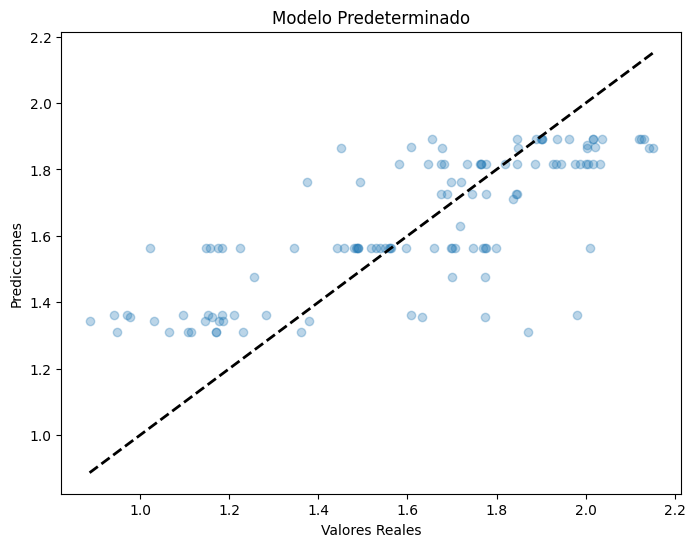

In [ ]:
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_test_pred = xg_reg.predict(X_test)

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Modelo Predeterminado')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea diagonal

plt.show()


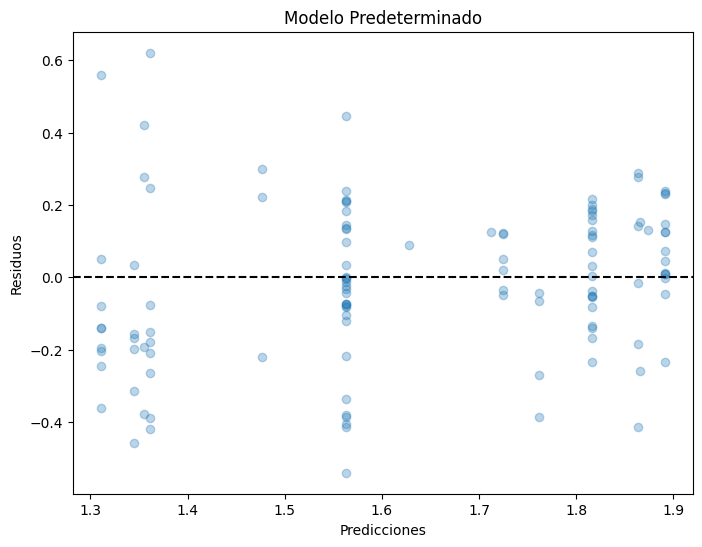

In [ ]:
# Calcular residuos
residuals = y_test - y_test_pred

# Crear el gráfico de residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Modelo Predeterminado')

plt.axhline(y=0, color='k', linestyle='--')  # Línea horizontal en 0

plt.show()

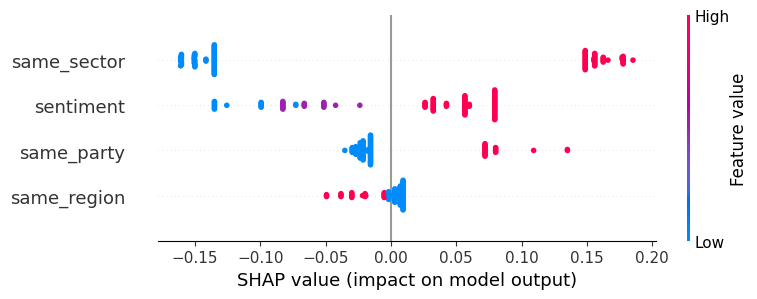

In [ ]:
import shap

explainer = shap.Explainer(xg_reg)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# Concatatenar vectores de nodos

In [ ]:
import pandas as pd

# Expandir las tuplas de vectores en columnas separadas
node_vector_1_df = pd.DataFrame(df_merged['node_vector_1'].tolist(), columns=[f'node_vector_1_{i+1}' for i in range(len(df_merged['node_vector_1'][0]))])
node_vector_2_df = pd.DataFrame(df_merged['node_vector_2'].tolist(), columns=[f'node_vector_2_{i+1}' for i in range(len(df_merged['node_vector_2'][0]))])

# Concatenar las columnas expandidas con el DataFrame original
X = pd.concat([df_merged[['same_party', 'same_sector', 'same_region', 'sentiment', 'same_comunity']],
                         node_vector_1_df,
                         node_vector_2_df], axis=1)
y = df_merged['proportion_agreement']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample= 0.7, colsample_bytree=0.8, learning_rate=0.1,
                          max_depth=3, alpha=1, n_estimators=100, min_child_weight=5, gamma=0)

xg_reg.fit(X_train, y_train)


# Predecir en el conjunto de entrenamiento y prueba
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)


# Calcular métricas para el conjunto de entrenamiento
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rsr, train_vaf = calculate_rsr_vaf(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rsr, test_vaf = calculate_rsr_vaf(y_test, y_test_pred)

# Crear un DataFrame con los resultados del modelo
model_results_df = pd.DataFrame([{
    'Model': 'Modelo concatenación de node2vec',
    'Training_R2': train_r2,
    'Training_RMSE': train_rmse,
    'Training_RSR': train_rsr,
    'Training_VAF': train_vaf,
    'Testing_R2': test_r2,
    'Testing_RMSE': test_rmse,
    'Testing_RSR': test_rsr,
    'Testing_VAF': test_vaf
}])

# Concatenar los resultados al DataFrame existente
results_df = pd.concat([results_df, model_results_df], ignore_index=True)
print(f"RMSE Entrenamiento: {train_rmse}")
print(f"RMSE Prueba: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R² test: {test_r2}")
print(f"R² train: {train_r2}")

RMSE Entrenamiento: 0.12831704813237366
RMSE Prueba: 0.1638492080851813
MAE: 0.12853527055629427
R² test: 0.7515652991389182
R² train: 0.8324381593535867


<ipython-input-85-ede77d2402e0>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, model_results_df], ignore_index=True)


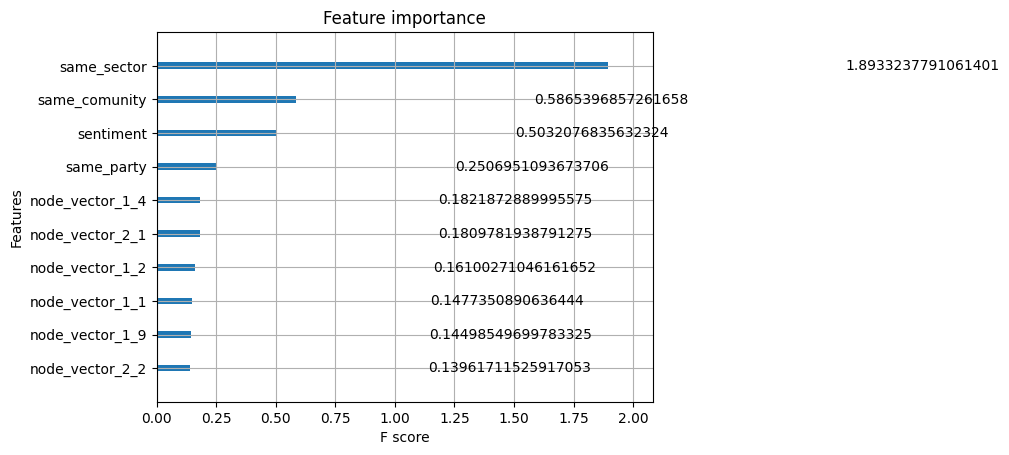

In [ ]:
xgb.plot_importance(xg_reg, importance_type='gain', max_num_features=10)
plt.show()

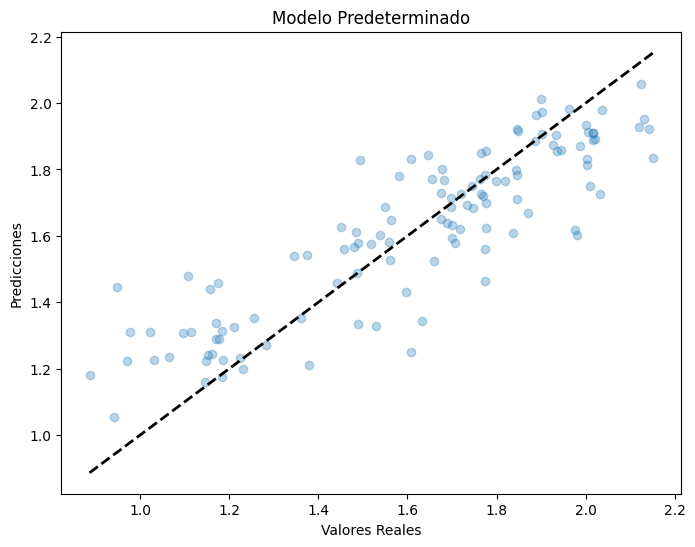

In [ ]:
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_test_pred = xg_reg.predict(X_test)

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Modelo Predeterminado')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea diagonal

plt.show()

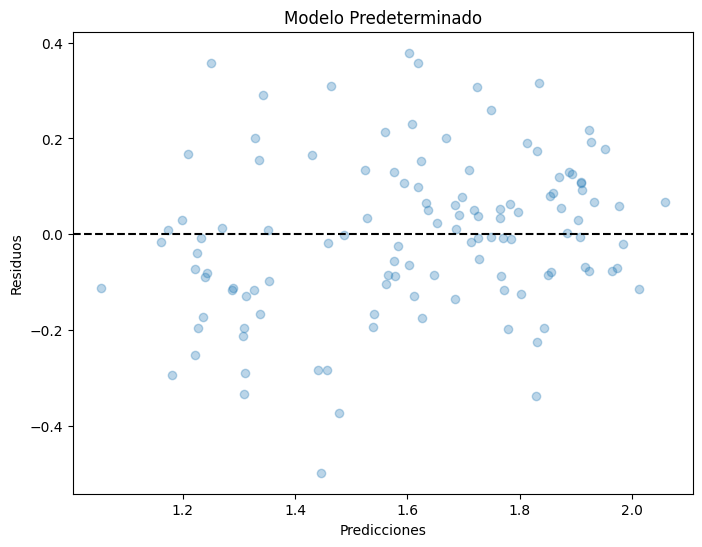

In [ ]:
# Calcular residuos
residuals = y_test - y_test_pred

# Crear el gráfico de residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Modelo Predeterminado')

plt.axhline(y=0, color='k', linestyle='--')  # Línea horizontal en 0

plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
# Validación cruzada
cv_scores = cross_val_score(xg_reg, X, y, cv=5, scoring='neg_mean_squared_error')

# Convertir scores negativos a positivos y calcular el RMSE
cv_rmse = np.sqrt(-cv_scores)

print(f"RMSE de Validación Cruzada: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

RMSE de Validación Cruzada: 0.3005 ± 0.1370


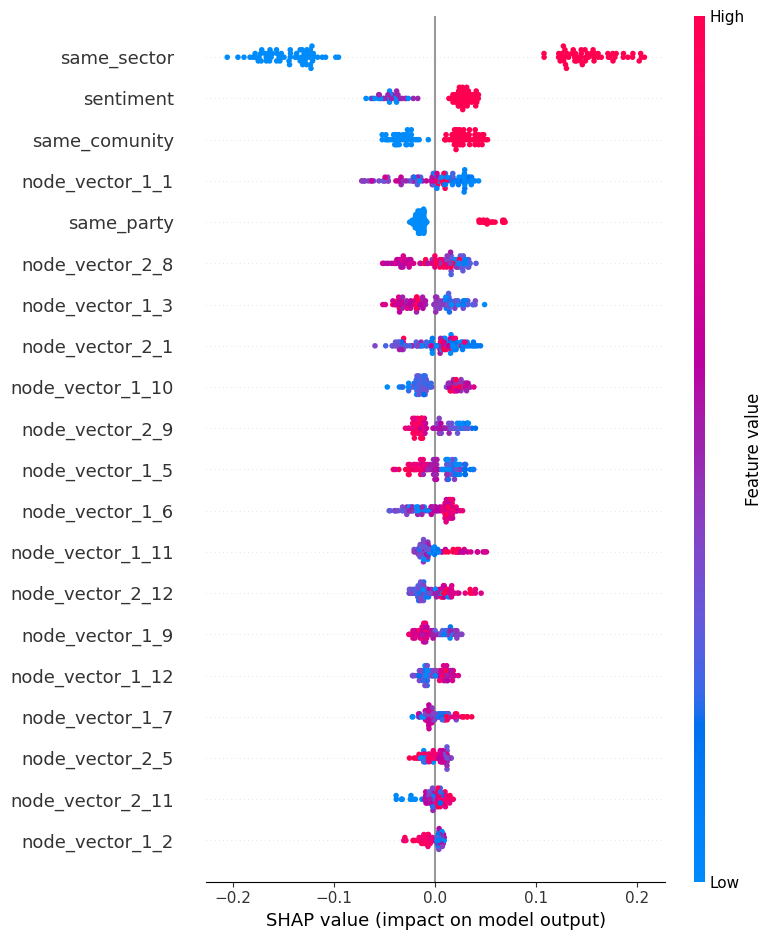

In [ ]:
import shap

explainer = shap.Explainer(xg_reg)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# Producto (multiplicacion elemento a elemento)

In [ ]:
# Calcular el producto de Hadamard (multiplicación elemento a elemento)
X_producto_hadamard = pd.concat([
    df_merged[['same_party', 'same_sector', 'same_region', 'sentiment', 'same_comunity']],
    pd.DataFrame([np.multiply(v1, v2) for v1, v2 in zip(df_merged['node_vector_1'], df_merged['node_vector_2'])], columns=[f'producto_hadamard_{i+1}' for i in range(len(df_merged['node_vector_1'][0]))])
], axis=1)

y_producto_hadamard = df_merged['proportion_agreement']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_producto_hadamard, y_producto_hadamard, test_size=0.2, random_state=42)


# Crear el modelo XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample= 0.7, colsample_bytree=0.8, learning_rate=0.1,
                          max_depth=3, alpha=1, n_estimators=100, min_child_weight=5, gamma=0)

xg_reg.fit(X_train, y_train)

# Predecir en el conjunto de entrenamiento y prueba
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)

# Calcular métricas para el conjunto de entrenamiento
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rsr, train_vaf = calculate_rsr_vaf(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rsr, test_vaf = calculate_rsr_vaf(y_test, y_test_pred)

# Crear un DataFrame con los resultados del modelo
model_results_df = pd.DataFrame([{
    'Model': 'Modelo Producto de node2vec',
    'Training_R2': train_r2,
    'Training_RMSE': train_rmse,
    'Training_RSR': train_rsr,
    'Training_VAF': train_vaf,
    'Testing_R2': test_r2,
    'Testing_RMSE': test_rmse,
    'Testing_RSR': test_rsr,
    'Testing_VAF': test_vaf
}])

# Concatenar los resultados al DataFrame existente
results_df = pd.concat([results_df, model_results_df], ignore_index=True)
print(f"RMSE Entrenamiento: {train_rmse}")
print(f"RMSE Prueba: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R² test: {test_r2}")
print(f"R² train: {train_r2}")

RMSE Entrenamiento: 0.1347091608761733
RMSE Prueba: 0.16029758144846856
MAE: 0.12754158295903098
R² test: 0.7622188060700644
R² train: 0.815328165493844


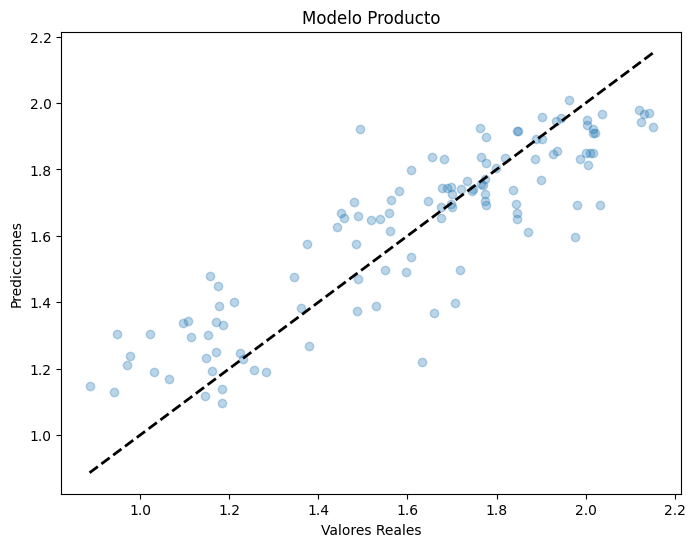

In [ ]:
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_test_pred = xg_reg.predict(X_test)

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Modelo Producto')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea diagonal

plt.show()

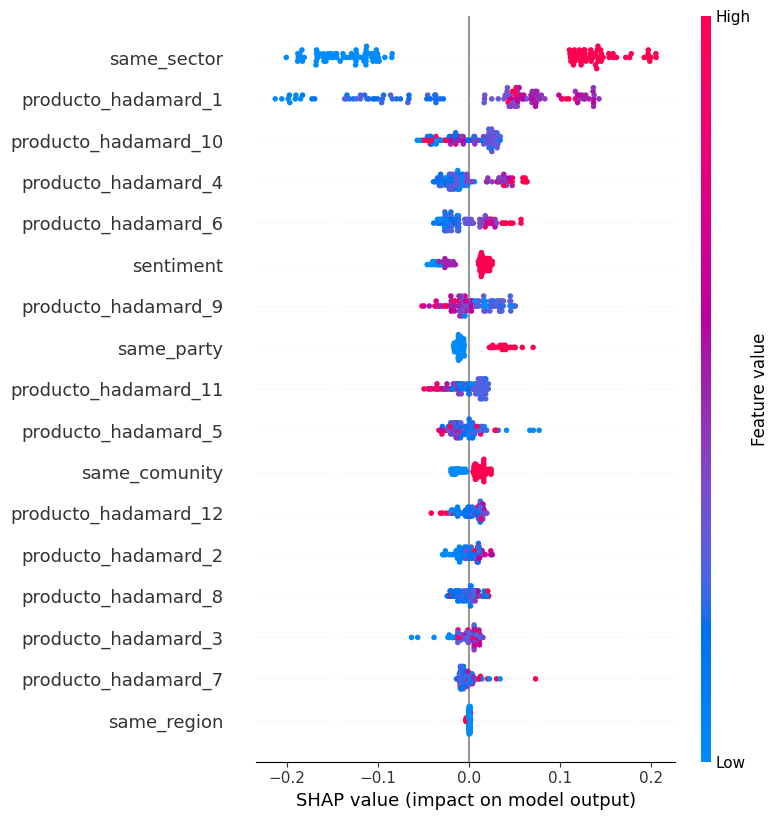

In [ ]:
import shap

explainer = shap.Explainer(xg_reg)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# Calcular promedio

In [ ]:
# Calcular el promedio entre node_vector_1 y node_vector_2
X_promedio = pd.concat([
    df_merged[['sentiment', 'same_comunity']],
    pd.DataFrame([(np.array(v1) + np.array(v2)) / 2 for v1, v2 in zip(df_merged['node_vector_1'], df_merged['node_vector_2'])], columns=[f'promedio_{i+1}' for i in range(len(df_merged['node_vector_1'][0]))])
], axis=1)

y_promedio = df_merged['proportion_agreement']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_promedio, y_promedio, test_size=0.2, random_state=42)

# Crear el modelo XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', subsample= 0.8, colsample_bytree=0.7, learning_rate=0.1,
                          max_depth=3, alpha=1, n_estimators=100, min_child_weight=4, gamma=0)

xg_reg.fit(X_train, y_train)

# Predecir en el conjunto de entrenamiento y prueba
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)

# Calcular métricas para el conjunto de entrenamiento
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_rsr, train_vaf = calculate_rsr_vaf(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rsr, test_vaf = calculate_rsr_vaf(y_test, y_test_pred)

# Crear un DataFrame con los resultados del modelo
model_results_df = pd.DataFrame([{
    'Model': 'Modelo promedio de node2vec',
    'Training_R2': train_r2,
    'Training_RMSE': train_rmse,
    'Training_RSR': train_rsr,
    'Training_VAF': train_vaf,
    'Testing_R2': test_r2,
    'Testing_RMSE': test_rmse,
    'Testing_RSR': test_rsr,
    'Testing_VAF': test_vaf
}])

# Concatenar los resultados al DataFrame existente
results_df = pd.concat([results_df, model_results_df], ignore_index=True)
print(f"RMSE Entrenamiento: {train_rmse}")
print(f"RMSE Prueba: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R² test: {test_r2}")
print(f"R² train: {train_r2}")

RMSE Entrenamiento: 0.15347207097568255
RMSE Prueba: 0.2108345777882336
MAE: 0.16672949357862216
R² test: 0.5886540356500247
R² train: 0.7603016144592054


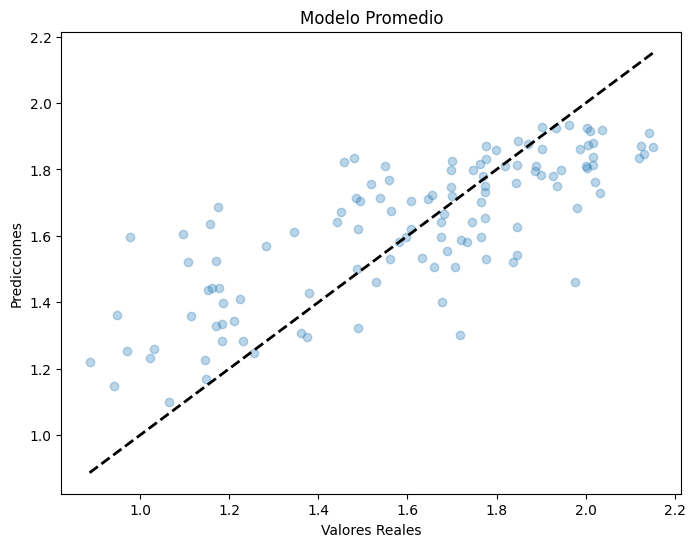

In [ ]:
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
y_test_pred = xg_reg.predict(X_test)

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Modelo Promedio')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea diagonal

plt.show()

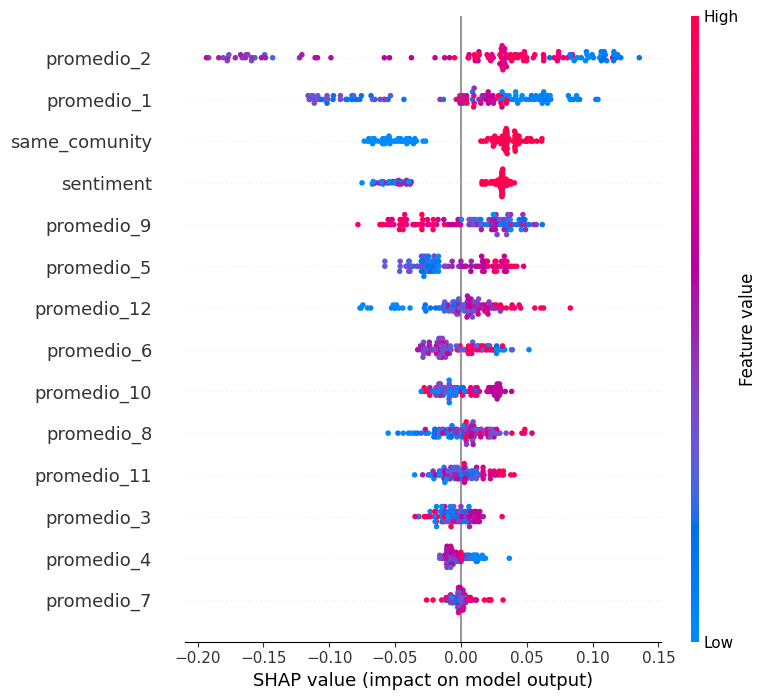

In [ ]:
import shap

explainer = shap.Explainer(xg_reg)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# Resultados

In [ ]:
results_df

,Model,Training_R2,Training_RMSE,Training_RSR,Training_VAF,Testing_R2,Testing_RMSE,Testing_RSR,Testing_VAF
0,Modelo concatenación de node2vec,0.832438,0.128317,0.128317,0.832438,0.751565,0.163849,0.163849,0.751565
1,Modelo Base,0.443833,0.233776,0.233776,0.443833,0.557045,0.218785,0.218785,0.557045
2,Modelo Producto de node2vec,0.815328,0.134709,0.134709,0.815328,0.762219,0.160298,0.160298,0.762219
3,Modelo promedio de node2vec,0.874291,0.111142,0.111142,0.874291,0.589620,0.210587,0.210587,0.589620
4,Modelo promedio de node2vec,0.760302,0.153472,0.153472,0.760302,0.588654,0.210835,0.210835,0.588654



| Model                             | Training_R2 | Training_RMSE | Training_RSR | Training_VAF | Testing_R2 | Testing_RMSE | Testing_RSR | Testing_VAF |
|------------------------------------|-------------|---------------|--------------|--------------|------------|--------------|-------------|-------------|
| Modelo Base                        | 0.443833    | 0.233776      | 0.233776     | 0.443833     | 0.557045   | 0.218785     | 0.218785    | 0.557045    |
| Modelo concatenación de node2vec   | 0.832438    | 0.128317      | 0.128317     | 0.832438     | 0.751565   | 0.163849     | 0.163849    | 0.751565    |
| Modelo Producto de node2vec        | 0.815328    | 0.134709      | 0.134709     | 0.815328     | 0.762219   | 0.160298     | 0.160298    | 0.762219    |
| Modelo promedio de node2vec        | 0.874291    | 0.111142      | 0.111142     | 0.874291     | 0.589620   | 0.210587     | 0.210587    | 0.589620    |


| Model                          | Training_R2 | Training_RMSE | Training_RSR | Training_VAF | Testing_R2 | Testing_RMSE | Testing_RSR | Testing_VAF |
|--------------------------------|-------------|---------------|--------------|--------------|------------|--------------|-------------|-------------|
| Modelo Base                    | 0.443833    | 0.233776      | 0.233776     | 0.443833     | 0.557045   | 0.218785     | 0.218785    | 0.557045    |
| Modelo concatenación de node2vec | 0.825741    | 0.130856      | 0.130856     | 0.825741     | 0.706351   | 0.178136     | 0.178136    | 0.706351    |
| Modelo Producto de node2vec    | 0.826161    | 0.130699      | 0.130699     | 0.826161     | 0.687704   | 0.183705     | 0.183705    | 0.687704    |
| Modelo promedio de node2vec    | 0.878747    | 0.109155      | 0.109155     | 0.878747     | 0.564321   | 0.216981     | 0.216981    | 0.564321    |
